## Ch1. Attention机制


### 1. 认知科学中的注意力

注意力是指人在关注一些信息的同时忽略另一些信息的选择能力。在生活中人脑可以在大量的输入信息中选择部分的有用信息的重点来处理，这种能力就是注意力。
注意力一般分为两种：
- 聚焦式注意力（focus attention）：自上而下的有意识的注意力被称为聚焦式注意力，这是一种有预定目的的、依赖任务的，主动有意识的聚焦于某一对象的注意力。
- 基于显著性的注意力（saliency-based attention）：自下而上的无意识的注意力被称为基于显著性的注意力，这是由外界刺激驱动的注意，不需要主动干预也和外界无关。

### 2. 神经网络中的注意力机制

在计算能力有限的情况下，我们可以为神经网络引入注意力机制，作为一种资源分配方案，这种将有限的资源用来处理重要信息的方式，是神经网络处理信息超载的主要手段。即当我们使用神经网络；来处理大量的输入信息时，可以借鉴人脑的注意力机制，只选择一些关键的信息输入我们的网络，从而提高神经网络的效率。

以NLP任务中经典的阅读理解任务为例，当我们给定一篇内容很长的文章，向神经网络就此文章的内容进行提问。我们的提问至于文章中的某些片段、某些句子有关，其余部分都是无关的，那么我们就可以只把相关的片段挑选出来作为神经网络的输入，而不需要把整篇文章都输入网络来减小网络的计算负担。

在神经网络中，我们可以将最大池化（max pooling）与门控机制（gating）近似的看作自下而上的注意力，而我们可以通过计算注意力分布的方式来实现子上而下的注意力。注意力机制的计算主要分为两步：

1. 在所有信息上计算注意力分布
2. 根据注意力分布来计算输入信息的加权平均

### 3. 注意力机制的计算

#### 3.1 注意力分布

我们用$ \mathbf{X} = \begin{bmatrix} \mathbf{x_1}, ..., \mathbf{x_n} \end{bmatrix} \in \mathbb{R^{D \times N}} $来表示$\mathbf{N}$组输入信息，其中的$\mathbf{D}$维向量$\mathbf{x_n} \in \mathbb{R^D}, n \in [1, N]$表示一组输入信息。

为了从$\mathbf{X}$中选择出与某个特定任务相关的信息，我们引入一个与任务相关的表示——查询向量$\mathbf{q}$（Query Vector）。例如在文本理解的任务中，这个查询向量就可以是我们所提出的问题的一个embedding的向量。给定一个查询向量$\mathbf{q}$，我们使用注意力变量$z \in [1, N]$来表示被选择的信息的索引位置，例如$z = n$就表示我们选择了$\mathbf{X}$中的第n个输入向量。

首先，我们通过一个打分函数来计算每个输入向量与查询向量之间的相关性，假设$s(\mathbf{x}, \mathbf{q})$为注意力打分函数，我们通常可以使用以下几种方式来计算打分函数（$\mathbf{v}、\mathbf{W}、\mathbf{U}$均为可学习的参数）：
1. 加性模型：$s(\mathbf{x}, \mathbf{q}) = \mathbf{v}^T tanh(\mathbf{W} \mathbf{x} + \mathbf{U} \mathbf{q}) \tag{1.1}$
2. 点积模型：$s(\mathbf{x}, \mathbf{q}) = \mathbf{x}^T \mathbf{q} \tag{1.2}$
3. 点积缩放模型：$s(\mathbf{x}, \mathbf{q}) = \frac{\mathbf{x}^T \mathbf{q}}{\sqrt{D}} \tag{1.3}$
4. 双线性模型: $s(\mathbf{x}, \mathbf{q}) = \mathbf{x}^T \mathbf{W} \mathbf{q} \tag{1.4}$

在通过如上的计算得到注意力得分后，我们就可以进一步计算在给定$\mathbf{q}$和$\mathbf{x}$的情况下，选择到第$n$条输入向量的概率$\mathbf{\alpha_n}$，即注意力分布（attention distributed）：

$$
    \mathbf{\alpha_n} = p(z = n | \mathbf{X}, \mathbf{q}) \\
                   = softmax(s(\mathbf{x_n}, \mathbf{q})) \\
                   = \frac{exp(s(\mathbf{x_n}, \mathbf{q}))}{\sum^N_j exp(s(\mathbf{x_j}, \mathbf{q}))} \tag{1.5}
$$

#### 3.2 注意力机制

#### 3.2.1 soft attention mechanism

注意力分布$ \mathbf{\alpha_n} $可以解释为在给定任务相关的查询向量$ \mathbf{q} $时，第$n$个输入向量受关注的程度。我们可以使用一种soft性质的信息汇总方式对输入信息进行汇总，即使用加权平均的方式来计算注意力：

$$
 attn(\mathbf{X}, \mathbf{q}) = \sum^N_{n=1} \mathbf{\alpha_n} \mathbf{x_n} \\
                              = \mathbb{E}_{z \sim p(z|\mathbf{X}, \mathbf{q})} [\mathbf{x_z}] \tag{1.6}
$$ 

公式$\tag{1.6}$提到的注意力被称为软性注意力（soft attention），这种计算方式所选择的信息是所有输入向量在注意力分布下的期望。

#### 3.2.2 hard attention mechanism

除了上面提到的将输入在注意力分布下的期望作为输入的软性注意力机制外，还有一种住关注于某一输入向量的注意力，我们称之为硬性注意力（hard attention）。硬性注意力主要有两种实现方式：

1. 选取概率最高的一个输入向量作为神经网络的输入：

$$
 attn(\mathbf{X}, \mathbf{q}) = \mathbf{x_{\hat n}} \tag{1.7} \\
 x_{\hat n} = \arg \mathop{\max} \limits_{n=1}^N \mathbf{\alpha_n} \tag{1.8}
$$

2. 通过在注意力分布上进行随机采样来实现。

hard attention的一个缺点就是基于最大采样或者随机采样的方式来选择信息，这导致最终的损失函数与注意力分布之间的函数关系不可导，因此无法使用反向传播算法来进行训练。所以在神经网络中我们通常选取soft attention，而在强化学习中一般选取hard attention。

#### 3.2.3 key-value pair attention

在更一般的情况中，我们可以使用键值对（key-value pair）格式来表示输入信息，其中的key用来计算注意力分布$\mathbf{\alpha_n}$，value用来计算聚合信息。我们使用$(\mathbf{K}, \mathbf{V}) = \begin{bmatrix} (\mathbf{k_1}, \mathbf{v_1}), ..., (\mathbf{k_n}, \mathbf{v_n}) \end{bmatrix}$来表示$N$组输入信息，当我们给定任务相关的查询向量$\mathbf{q}$时，可以通过如下的方式来计算注意力函数：

$$
 att((\mathbf{K}, \mathbf{V}), \mathbf{q}) = \sum^N_{n=1} \mathbf{\alpha_n} \mathbf{v_n} \\
                                           = \sum^N_{n=1} \frac{exp(s(\mathbf{k_n}, \mathbf{q}))}{\sum_j exp(s(\mathbf{k_j}, \mathbf{q}))} \mathbf{v_n} \tag{1.9}
$$

可以注意到，当$\mathbf{K} = \mathbf{V}$时，键值对模式就等价于普通的注意力机制。

#### 3.2.4 multi-head attention
多头注意力就是在键值对注意力的基础上，利用多个查询$\mathbf{Q} = \begin{bmatrix} \mathbf{q_1}, ..., \mathbf{q_n} \end{bmatrix}$，来并行的从输入信息中选取多组神经网络的输入，其中每个注意力关注于输入信息的不同部分：
$$
 att((\mathbf{K}, \mathbf{V}), \mathbf{Q}) = att((\mathbf{K}, \mathbf{V}), \mathbf{q_1}) \oplus ... \oplus att((\mathbf{K}, \mathbf{V}), \mathbf{q_n}) \tag{1.10}
$$
我们用$\oplus$表示向量拼接。

### 3.3 注意力机制的代码实现

在NLP任务中，通过引入注意力机制，模型可以在每个时间步中为输入序列中不同位置的词分配不同的注意力权重，这样可以使得模型能够灵活的捕捉上下文关系，模型的性能也会相应的有所提高。

#### 3.3.1 注意力可视化函数

为了更好的对注意力机制进行展示，在实现注意力机制之前我们首先定义一个可以将注意力权重矩阵可视化的函数，使用该函数对注意力进行可视化有助于我们对注意力有一个更加直观的理解。

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def visualize_attn(attn_weights, src_seq=None, pred_seq=None):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
        data=attn_weights,
        annot=True,
        cbar=False,
        xticklabels=src_seq,
        yticklabels=pred_seq,
        cmap='Greens'
    )
    plt.xlabel('Source Sequence')
    plt.ylabel('Object Sequence')
    plt.show()

#### 3.3.2 点积注意力的实现
首先我们来实现最简单的一种注意力——点积注意力。首先创建两个张量$\mathbf{q}_{b \times x_1 \times f}$与$\mathbf{x}_{b \times x_2 \times f}$，分别代表与任务相关的查询与输入向量。其中$b$、$x_1$、$x_2$、$f$分别代表batch size、查询数目、输入向量维度、特征维度。之后按照点积注意力的计算方式，计算$\mathbf{q}$对$\mathbf{x}$的注意力。

首先导入相关的包

In [50]:
import torch
import torch.nn.functional as F

创建两个张量，$\mathbf{q}$与$\mathbf{x}$

In [51]:
q = torch.randn(2, 3, 4)
x = torch.randn(2, 5, 4)

In [52]:
q

tensor([[[-3.7993e-01,  1.6359e+00, -1.1666e+00,  1.0891e+00],
         [-7.2486e-01, -2.9193e-03,  1.4456e+00,  8.6442e-01],
         [-1.3432e+00, -6.4080e-02,  2.8507e-01, -9.4802e-01]],

        [[ 2.3784e-01,  7.8851e-01, -8.6622e-01,  4.3512e-01],
         [-3.4282e+00,  9.2850e-01,  1.5533e+00, -5.7722e-01],
         [ 1.0392e+00,  1.2234e+00, -7.6327e-01, -9.0406e-01]]])

In [53]:
x

tensor([[[ 1.4633,  1.4517,  0.3354, -0.1453],
         [ 0.7427, -0.6976,  1.5301, -0.6461],
         [ 0.3122, -0.9315, -0.4120, -0.7891],
         [ 0.7397, -0.2702, -0.2927, -0.4494],
         [-0.5441, -1.0573, -0.9918,  0.1248]],

        [[-1.0618,  1.1657,  0.5239,  0.4124],
         [-1.9964,  0.5106, -0.1898,  0.6005],
         [ 0.0496, -1.3471,  0.9425, -0.5060],
         [ 1.6103,  0.9451, -0.5656, -0.2175],
         [-1.7219,  0.0420, -1.4011,  0.7675]]])

在实践中，我们需要保持这两个张量的特征维度是一致的，在计算注意力分布时，我们需要在特征空间中对对应的元素进行点积，如果张良的特征维度不一致，那么我们就需要先进行线性变换，使其特征维度相等再进行操作。$\mathbf{x}$与$\mathbf{q}$可以分别代表对应encoder与decoder中的序列向量（decoder向量关注encoder向量），或者也可以表示任意两个序列甚至是同一个序列（self-attention）。

接下来我们进行点积计算，对$\mathbf{x}$进行转置操作，然后将两个张量点积，得到$\mathbf{q}$对$\mathbf{x}$的相关性或者相似性得分。

In [54]:
raw_weights = torch.bmm(q, x.transpose(1, 2))
raw_weights

tensor([[[ 1.2695, -3.9122, -2.0213, -0.8709, -0.2298],
         [-0.7057,  1.1170, -1.5012, -1.3470, -0.9283],
         [-1.8251,  0.0958,  0.2710, -0.6337,  0.3975]],

        [[ 0.3923,  0.3535, -2.0870,  1.5235,  1.1712],
         [ 5.2982,  6.6767,  0.3350, -5.3958,  3.3226],
         [-0.4501, -1.8480, -1.8583,  3.4578, -1.3624]]])

In [55]:
raw_weights.shape

torch.Size([2, 3, 5])

随后，我们使用softmax函数沿着$x_2$的方向对我们的初始相似度得分进行归一化，得到我们对应的注意力分布。我们把$\mathbf{x}$中每个位置对应的元素相似度的值进行归一化，这样就可以求得$\mathbf{q}$对$\mathbf{x}$中每一位置的关注程度。最后我们将计算得到的注意力分布与$mathbf{x}$相乘，就得到注意力权重的加权和。

In [61]:
attn_weights = F.softmax(raw_weights, dim=-1)
attn_outputs = torch.bmm(attn_weights, x)

In [62]:
attn_weights

tensor([[[7.2269e-01, 4.0606e-03, 2.6902e-02, 8.4992e-02, 1.6136e-01],
         [1.1152e-01, 6.9015e-01, 5.0332e-02, 5.8727e-02, 8.9265e-02],
         [3.5105e-02, 2.3968e-01, 2.8558e-01, 1.1556e-01, 3.2408e-01]],

        [[1.3653e-01, 1.3134e-01, 1.1442e-02, 4.2318e-01, 2.9751e-01],
         [1.9551e-01, 7.7601e-01, 1.3668e-03, 4.4344e-06, 2.7115e-02],
         [1.9347e-02, 4.7810e-03, 4.7318e-03, 9.6337e-01, 7.7695e-03]]])

In [63]:
attn_outputs

tensor([[[ 1.0440,  0.8277,  0.0526, -0.1469],
         [ 0.6863, -0.4767,  0.9670, -0.5171],
         [ 0.2277, -0.7561, -0.0944, -0.3968]],

        [[-0.2375,  0.6232, -0.5988,  0.2657],
         [-1.8034,  0.6234, -0.0816,  0.5667],
         [ 1.5080,  0.9294, -0.5421, -0.1951]]])

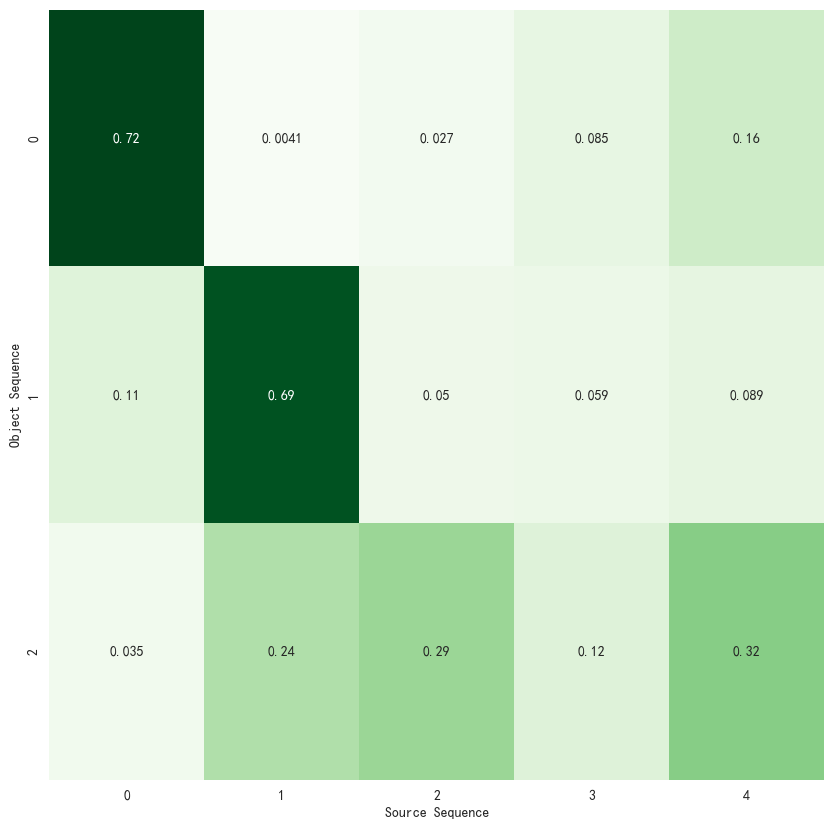

In [66]:
visualize_attn(
    attn_weights=attn_weights[0],
    src_seq=[i for i in range(x.size(1))],
    pred_seq=[j for j in range(q.size(1))]
)

以上就是我们对于点积注意力的实现。最终我们可以得到一个$b \times x_1 \times x_2$的注意力矩阵，这个矩阵表示着$\mathbf{q}$对$\mathbf{x}$每一个对应元素的“关注度”。但是在深度学习模型中，点积的值可能会变得非常大，这种情况在特征维度较大时将会变得更为明显。在点积值过大时，softmax函数可能会在一个非常陡峭的区间运行，这会导致梯度变得非常小，会导致在训练的过程中的梯度消失。为了解决点积导致的这个问题，后来提出了点积缩放注意力，通过为点积的结果除以一个缩放因子，从而保证softmax函数可以在一个平稳的区间内运行，从而减轻梯度消失的问题，提高模型的稳定性。

#### 3.3.3 点积缩放注意力的实现

除了与缩放因子有关的步骤外，点击缩放注意力的计算流程与点击注意力是相同的，点击缩放注意力可以看作是点积注意力的一个改进版本，用来解决模型中的梯度消失问题。我们通常选取输入向量的特征维度的大小的平方根来作为点积注意力的缩放因子。其具体实现流程如下：

In [67]:
q = torch.randn(2, 3, 4)
x = torch.randn(2, 5, 4)

raw_weights = torch.bmm(q, x.transpose(1, 2))
scaling_factor = x.size(-1)**0.5
scaled_weights = raw_weights / scaling_factor
attn_weights = F.softmax(scaled_weights, dim=2)
attn_outputs = torch.bmm(attn_weights, x)

In [68]:
attn_weights

tensor([[[0.1634, 0.2662, 0.0904, 0.4261, 0.0539],
         [0.1085, 0.1746, 0.1997, 0.4874, 0.0299],
         [0.1177, 0.0980, 0.4851, 0.1094, 0.1898]],

        [[0.3095, 0.1254, 0.0678, 0.1425, 0.3548],
         [0.4446, 0.0296, 0.0793, 0.2701, 0.1764],
         [0.0728, 0.1093, 0.4162, 0.1291, 0.2726]]])

In [69]:
attn_outputs

tensor([[[ 1.0789, -0.2987,  0.8267,  0.0083],
         [ 0.9565, -0.3159,  1.1151,  0.1137],
         [-0.2195,  0.0650,  0.7847,  0.9049]],

        [[-0.3376,  0.0839, -0.3260,  0.1658],
         [-0.4554,  0.3141,  0.2185,  0.0790],
         [-0.1089, -0.7143, -0.3122, -0.1763]]])

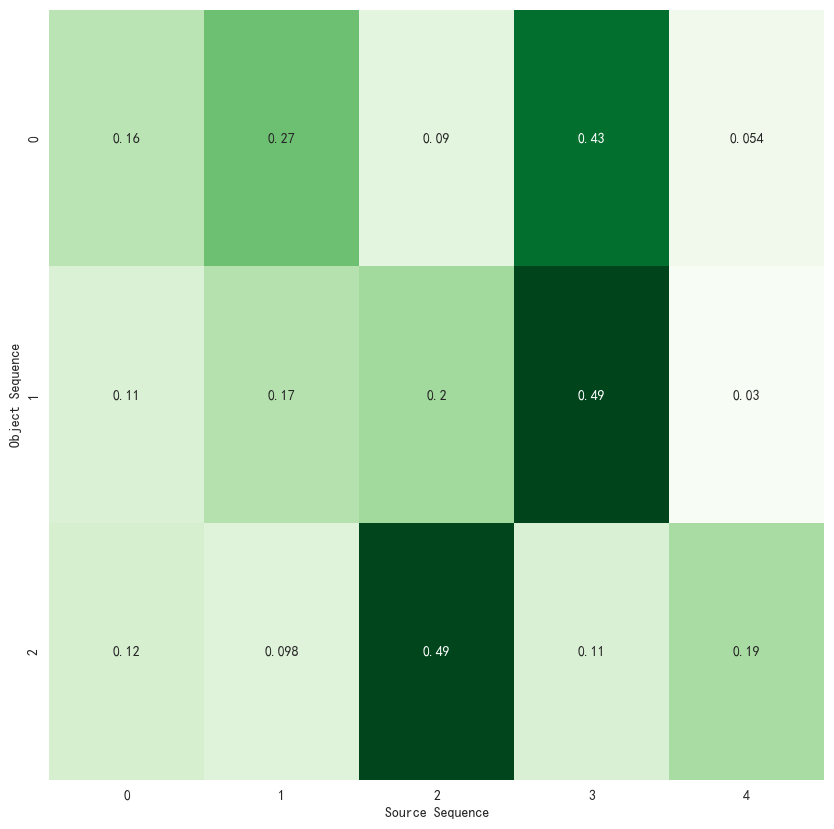

In [70]:
visualize_attn(
    attn_weights=attn_weights[0],
    src_seq=[i for i in range(x.size(1))],
    pred_seq=[j for j in range(q.size(1))]
)